# Inferring biological phases by clustering snapshots

Here, we infer biological phases of the cell cycle by clustering the snapshot of the temporal network.  
First, we compute a fixed number of clusters. Then, we compute a range of numbers of clusters, to explore a range of timescales. 

In [1]:
import string
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

import phasik as pk

# 1. Build temporal network

In [2]:
# load static network

static_net_filepath = "../data/kegg/static_PPI_network_KEGG.adjlist"
static_network = nx.read_adjlist(static_net_filepath)

# change names to match those in gene expression data
names_to_replace = {
    "APC": "CDC27",
    "SCF": "CDC53",
    "PP2A": "TPD3",
    "ORC": "ORC2",
    "MCM": "MCM2",
    "DDC2": "LCD1",
}

static_network = nx.relabel_nodes(static_network, names_to_replace)

print(pk.graph_size_info(static_network))

83 nodes and 159 edges


In [40]:
# load and format temporal data
edge_table_filepath = "../data_raw/kelliher/GSE80474_Scerevisiae_normalized.txt"

node_table = pd.read_csv(
    edge_table_filepath, sep="\t", index_col="time_points"
)  # , skipfooter=1, engine='python')

# uncomment if we want only the first i_end timepoints
dt = 2
dtt = 5 * dt
i_start = 4 - dt  # times_full.tolist().index(new_cycle_1) # = 4
i_end = 20 - dt  # times_full.tolist().index(new_cycle_2) # = 20
node_table = node_table.iloc[:, i_start:i_end]

n_times = node_table.shape[1]
times = node_table.columns.astype(int)
times = times - times[0]
node_table.columns = times

In [41]:
# determine events for plots below
data = pk.TemporalData.from_df(node_table.transpose(), times=times, true_times=times)

id_mbp1_max = np.argmax(data.series("MBP1"))
id_clb2_max = np.argmax(data.series("CLB2"))
id_clb1_max = np.argmax(data.series("CLB1"))

events_times = [
    0,
    times[id_mbp1_max],
    times[id_clb1_max],
    times[id_clb2_max],
    75,
]
events_labels = [
    "new cycle",
    "MBP1 max.",
    "CLB1 max.",
    "CLB2 max.",
    "new cycle",
]

events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]

In [42]:
# deal with potential ducplicate gene names (different affymatrix ids correspond to a single gene name)
node_table_formatted = node_table.transpose()
node_table_formatted.head()

# find duplicate nodes
mask = node_table_formatted.columns.duplicated()
duplicate_nodes = node_table_formatted.columns[mask].unique()  # in the node_table
duplicates_in_static_network = set(static_network.nodes).intersection(
    duplicate_nodes
)  # also in the static net
print(
    "More than one time series correspond to the following nodes of the static network (genes):"
)
print(f"{duplicates_in_static_network}")

# choose method to combine gene ids
combine_duplicates = "average"  # can also be 'first', 'last'

if combine_duplicates == "average":
    # replace duplicate gene columns by their average
    node_series = node_table_formatted.groupby(level=0, axis=1, sort=False).mean()
elif combine_duplicates == "first":
    # replace duplicate gene columns by the first time series
    node_series = node_table_formatted.groupby(level=0, axis=1, sort=False).first()
elif combine_duplicates == "last":
    # replace duplicate gene columns by the first time series
    node_series = node_table_formatted.groupby(level=0, axis=1, sort=False).last()
else:
    print("WARNING: method of combining duplicates not supported")

node_series = node_series.T

More than one time series correspond to the following nodes of the static network (genes):
set()


In [43]:
node_series

0       5       10      15      20      25     30     35  \
time_points                                                                
15S_rRNA     1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
21S_rRNA     1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
HRA1         1.533   1.381   1.199   1.000   1.000   1.000  1.000  1.159   
ICR1         4.252   4.448   4.905   6.976   6.323   6.342  5.770  6.511   
LSR1         8.903  23.702  22.792  29.675  22.024  44.021  8.011  7.492   
...            ...     ...     ...     ...     ...     ...    ...    ...   
ARR3         3.783   3.309   3.980   3.451   2.948   3.582  3.853  4.118   
YPR202W      1.249   2.338   2.817   2.779   1.814   1.937  2.686  1.893   
YPR203W      1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
YPR204C-A    1.000   1.000   1.000   1.000   1.000   1.000  1.000  1.000   
YPR204W      1.221   1.498   1.471   1.631   1.557   1.380  1.359  1.099   

                 40     45      50      55      60     65     70     75  
time_points                                                              
15S_rRNA      1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
21S_rRNA      1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
HRA1          1.362  1.668   1.171   1.000   1.000  1.000  1.299  1.000  
ICR1          5.972  5.957   5.206   6.427   8.070  9.647  9.703  8.320  
LSR1         10.609  9.735  12.841  15.096  21.682  8.668  7.543  8.297  
...             ...    ...     ...     ...     ...    ...    ...    ...  
ARR3          4.033  3.678   3.737   4.083   3.458  4.044  3.503  2.960  
YPR202W       1.763  1.352   1.599   2.321   2.178  2.935  1.944  1.585  
YPR203W       1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
YPR204C-A     1.000  1.000   1.000   1.000   1.000  1.000  1.000  1.000  
YPR204W       1.158  1.333   1.276   1.328   1.302  1.514  1.484  1.622  

[7126 rows x 16 columns]

In [44]:
# build temporal network
temporal_network = pk.TemporalNetwork.from_static_network_and_node_timeseries(
    static_network,
    node_series,
    combine_node_weights=lambda x, y: x * y,
    static_edge_default_weight=1,
    normalise="max",
    quiet=False,
)

temporal_network_name = f"kegg_kelliher"

A PartiallyTemporalNetwork is created instead.
Edges with no temporal information:
{('Cohesin', 'ESP1')}


## Single number of clusters

In [45]:
# clustering parameters
distance_metric = "euclidean"  # used to compute distance between snapshots
clustering_method = "ward"  # used to compute the distance between clusters
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

# plotting parameters
output_directory = "images/kelliher/"
Path(output_directory).mkdir(parents=True, exist_ok=True)

# events_times = [5, 33, 36, 70, 84, 100]
# events_labels = ['START', 'bud', 'ori', 'E3', 'spn', 'mass']
# events = [(time, name, 'dashed') for time, name in zip(events_times, events_labels)]

dtt = 5 * dt
phases = [
    (0, 5 + dtt, "G1"),
    (5 + dtt, 25 + dtt, "S"),
    (25 + dtt, 40 + dtt, "G2"),
    (40 + dtt, 75, "M"),
]

# time_ticks = true_times
# variables_to_plot = []

In [46]:
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)

cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

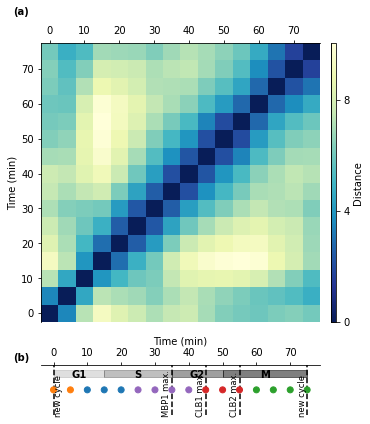

In [58]:
gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gs_kw, sharex=False, figsize=(5, 7))

# distance matrix
im = ax1.imshow(
    distance_matrix.distance_matrix,
    aspect="equal",
    origin="lower",
    cmap="YlGnBu_r",
)
sb.despine(ax=ax1, top=False, bottom=True)


def compute_ticklabels(times):

    n_ticks_auto = (
        len(ax1.get_yticks()) - 2
    )  # matplotlib places an extra tick on each side
    n_times = len(times)
    skip = n_times // n_ticks_auto
    return [str(i) for i in times[::skip]]


tick_labels = compute_ticklabels(times)

ax1.set_yticks(ax1.get_yticks().tolist()[1:-1])
ax1.set_xticks(ax1.get_xticks().tolist()[1:-1])

ax1.set_yticklabels(tick_labels)
ax1.set_xticklabels(tick_labels)

ax1.xaxis.set_label_position("top")
ax1.set_ylabel("Time (min)")

# clusters
cluster_set.plot(ax=ax2)

sb.despine(ax=ax2, left=True, bottom=True, top=False)
# only way to get rid of spine offset in scatter plot apparently
ax2.set_yticks([])
ax2.set_xlabel(f"Time (min)")
ax2.xaxis.set_label_position("top")

# plot_phases(phases, ax=ax2, y_pos=0.15, ymax=0.3)
pk.plot_events(events, ax=ax2, text_y_pos=-0.06, text_x_offset=1.5, va="bottom")
pk.plot_phases(phases, ax=ax2, y_pos=0.8, ymax=0.9, ymin=0.75)

# colorbar
cax = fig.add_axes((0, 0, 1, 0.1))
pos1 = ax1.get_position()  # get the original position
pos2 = [
    pos1.x0 + pos1.width + 0.03,
    pos1.y0,
    pos1.width * 0.02,
    pos1.height,
]  # vertical
cax.set_position(pos2)  # set a new position

cb = fig.colorbar(im, cax=cax)
cb.set_ticks([0, 4, 8])
cb.set_label("Distance")
sb.despine(ax=cax)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.1,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if output_directory is not None:
    filename = f"{output_directory}distmat_{cluster_set.n_clusters}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()

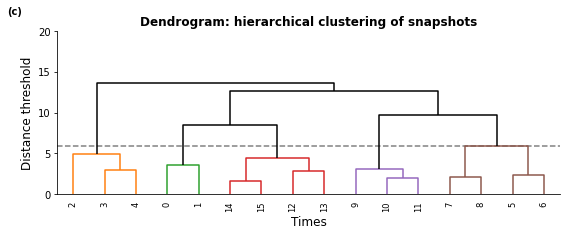

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

if clustering_method != "k_means":
    cluster_set.plot_dendrogram(ax=ax, leaf_font_size="small")

    ax.set_ylabel("Distance threshold", fontsize="large")
    ax.set_xlabel("Times", fontsize="large")
    ax.set_yticks(range(0, 21, 5))
    ax.set_title("Dendrogram: hierarchical clustering of snapshots", weight="bold")

sb.despine()

# label subplots
ax.text(-0.1, 1.1, f"(c)", transform=ax.transAxes, size="medium", weight="bold")


# Save
if output_directory is not None:
    filename = f"{output_directory}/dendrogram_{cluster_set.n_clusters}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()

## Range of number of clusters: exploring timescales

In [12]:
cluster_sets = pk.ClusterSets.from_distance_matrix(
    distance_matrix, n_max_type, n_max_range, clustering_method
)

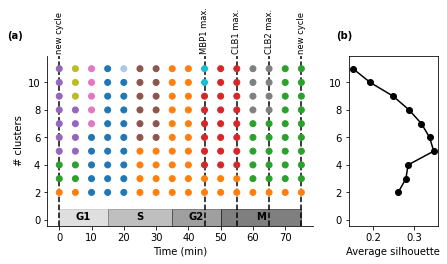

In [13]:
# Plot
gridspec_kw = {"width_ratios": [3, 1]}
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 3.5), gridspec_kw=gridspec_kw, sharey="all"
)

cluster_sets.plot(axs=(ax1, ax2), with_silhouettes=True)
pk.adjust_margin(ax=ax1, bottom=0.2 if phases else 0.05, top=0.05)
pk.plot_events(events, ax=ax1)

# Format
ax1.set_xlabel(f"Time (min)")
ax1.set_axisbelow(True)
ax1.set_ylabel("# clusters")
pk.plot_phases(phases, ax=ax1, y_pos=0.05, ymax=0.1)

time_ticks = np.arange(0, 75, 10)
ax1.set_xticks(time_ticks)
sb.despine(ax=ax1)

ax2.set_xlabel("Average silhouette")
ax2.yaxis.set_tick_params(labelleft=True)

plt.subplots_adjust(wspace=0.2, top=0.8)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.15,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if output_directory is not None:
    pass
    filename = f"{output_directory}/phase_clusters_all_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

### Aggregate over clusters, and get ranked list of edge activities

In [14]:
# compute list of ranked edges (by weight) for each cluster and save
# do this for several numbers of clusters

n_clusters_id_max = (
    5  # if 0, computes only for 2 clusters, if >0, cluster_sets.n_clusters[j] clusters
)
for j in range(n_clusters_id_max):
    clusters = cluster_sets.clusters[j]
    aggregates = pk.aggregate_network_by_cluster(
        temporal_network, clusters, sort_clusters=False
    )
    n_clusters = len(aggregates)
    print(f"computed for {n_clusters} clusters")

    for i in range(len(aggregates)):

        cluster = list(aggregates.keys())[i]
        network = list(aggregates.values())[i][0]
        time_indices = list(aggregates.values())[i][1]
        edge_weights = pk.weighted_edges_as_df(network)
        edge_weights.to_csv(
            f"{output_directory}clusters_{n_clusters}_{i}_timepoints_{time_indices}.csv",
            index=False,
            float_format="%.3f",
        )

computed for 2 clusters
computed for 3 clusters
computed for 4 clusters
computed for 5 clusters
computed for 6 clusters


In [15]:
# check the graph of one cluster in particular
n_clusters = 3
clusterset_id = list(cluster_sets.n_clusters).index(n_clusters)
clusters = cluster_sets.clusters[clusterset_id]
# dict with values (aggregated_graph, list of timepoints) for each cluster
aggregates = pk.aggregate_network_by_cluster(
    temporal_network, clusters, sort_clusters=False
)
aggregates

{1: (<networkx.classes.graph.Graph at 0x129cba790>, [2, 3, 4]),
 2: (<networkx.classes.graph.Graph at 0x129cbabb0>, [0, 1, 12, 13, 14, 15]),
 3: (<networkx.classes.graph.Graph at 0x129cbaac0>, [5, 6, 7, 8, 9, 10, 11])}

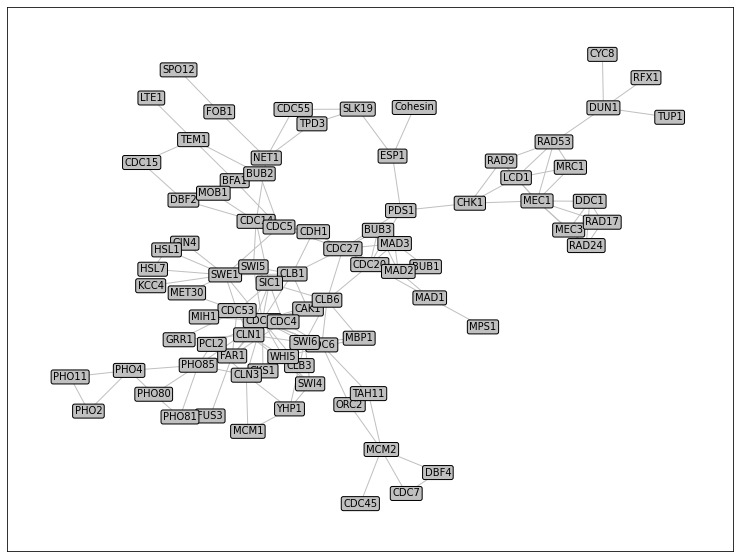

In [16]:
# plot aggregated graph

i = 1  # cluster label
G = aggregates[i][0]

fig, ax = plt.subplots(figsize=(13, 10))

pk.draw_graph(G, ax=ax, color="silver")
plt.show()

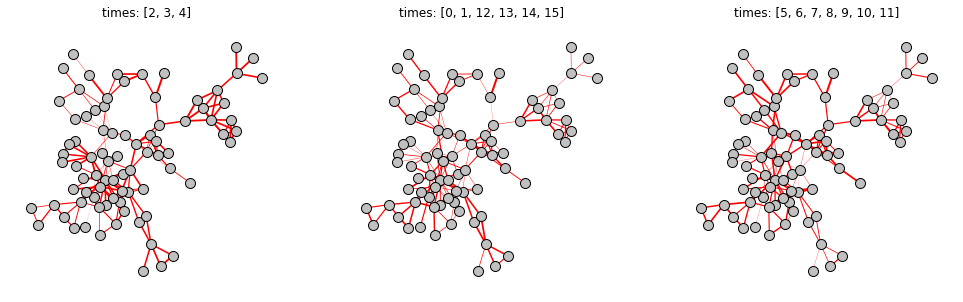

In [52]:
# plot all three clusters
# represent edge weights by edge width

fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i, j in enumerate(aggregates.keys()):
    G = aggregates[j][0]
    timepoints = aggregates[j][1]

    weights = np.array(list(nx.get_edge_attributes(G, "weight").values()))

    pk.draw_graph(
        G,
        ax=axs[i],
        color="silver",
        label_nodes=False,
        edge_widths=weights * 2,
        edge_colors="red",
    )
    axs[i].set_title(f"times: {timepoints}")

sb.despine(bottom=True, left=True)

plt.show()

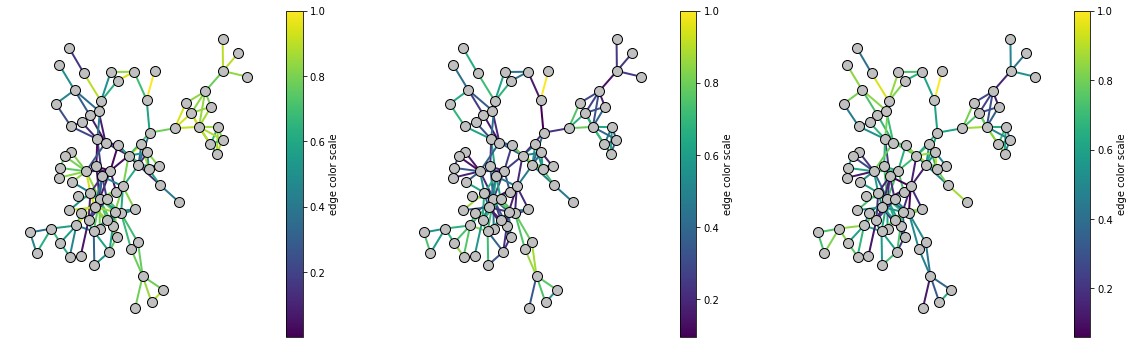

In [51]:
# or color edges by weights

# plot all three clusters

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, j in enumerate(aggregates.keys()):
    G = aggregates[j][0]

    weights = np.array(list(nx.get_edge_attributes(G, "weight").values()))

    pk.draw_graph(
        G,
        ax=axs[i],
        color="silver",
        label_nodes=False,
        edge_colors=weights,
        edge_widths=2,
    )

sb.despine(bottom=True, left=True)

plt.show()